```
Topic:        Challenge Set 8
Subject:      Classification Errors
Date:         02/05/2018
Name:         Brad Solomon
Worked with:  None
```

In [1]:
TEST_SIZE = 0.3
RANDOM_STATE = 444

# Challenges 1 & 2

<font color="blue">
For the house representatives data set, calculate the accuracy, precision, recall and f1 scores of each classifier you built (on the test set).
</font>

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'
names = ['party', 'hcap_infants', 'water_project', 'budget_res', 'fee_freeze', 'el_salvador',
         'relig_grps', 'sat_test', 'contras', 'missile', 'immigration', 'synfuels', 'educ',
         'superfund', 'crime', 'duty_free', 'south_africa']

df = pd.read_csv(path, header=None, names=names)
mapping = dict(y=1, n=0, democrat=1, republican=0)
df = df.applymap(lambda x: mapping.get(x, np.nan)).astype({'party': np.uint8})
df.fillna(df.mean(), inplace=True)
y = df.pop('party')

X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

neighbors = {'knn__n_neighbors': np.arange(1, 21, dtype=int)}
pipe = Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])

grid = GridSearchCV(pipe, param_grid=neighbors, cv=4, return_train_score=True)
grid.fit(X_train, y_train);

In [26]:
from sklearn.metrics import accuracy_score, classification_report

def make_full_report(grid, name, X_test, y_test):
    print(grid.best_estimator_.named_steps[name].__class__.__name__)
    print('-' * 20)
    print('Accuracy: {:0.3f}'.format(accuracy_score(y_test, grid.predict(X_test))))
    print()
    print(classification_report(y_test, grid.predict(X_test)))

make_full_report(grid, 'knn', X_test, y_test)

KNeighborsClassifier
--------------------
Accuracy: 0.954

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        51
          1       0.99      0.94      0.96        80

avg / total       0.96      0.95      0.95       131



0.999264705882


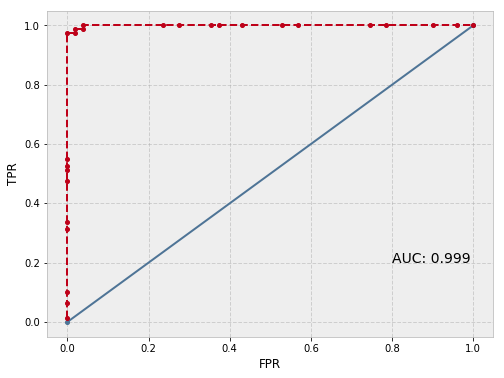

In [45]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(grid, X_test, y_test, figsize=(8, 6)):
    p = grid.predict_proba(X_test)[:, 1]
    fpr, tpr,_ = roc_curve(y_test, p)
    roc_auc = auc(fpr, tpr)
    print(roc_auc)

    plt.figure(figsize=figsize)
    plt.text(0.8, 0.2, 'AUC: {:0.3f}'.format(roc_auc), fontsize=14)
    plt.plot([0,1], [0,1])
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    return plt

plot_roc_curve(grid, X_test, y_test)
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression

c = {'logit__C': np.arange(.01, 2.02, .05)}
pipe = Pipeline([('scaler', StandardScaler()),
                 ('logit', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])

grid = GridSearchCV(pipe, param_grid=c, cv=4, return_train_score=True)
grid.fit(X_train, y_train)

make_full_report(grid, 'logit', X_test, y_test)

LogisticRegression
--------------------
Accuracy: 0.985

             precision    recall  f1-score   support

          0       0.96      1.00      0.98        51
          1       1.00      0.97      0.99        80

avg / total       0.99      0.98      0.98       131



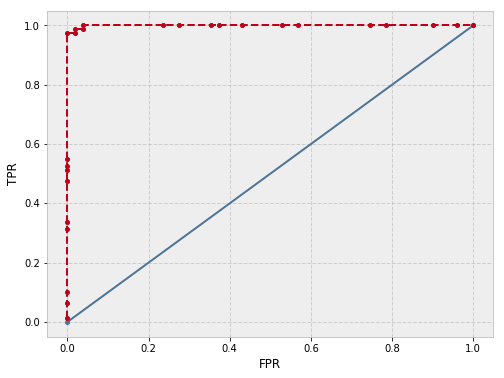

In [31]:
plot_roc_curve(grid, X_test, y_test)
plt.show()

# Challenge 3

<font color="blue">
Calculate the same metrics you did in challenge 1, but this time in a cross validation scheme with the cross_val_score function (like in Challenge 9).
</font>

Did this by default in Challenges 1 & 2.

# Challenge 4

<font color="blue">
For your movie classifiers, calculate the precision and recall for each class.
</font>

In [34]:
import re
import pandas as pd
from sklearn.preprocessing import LabelEncoder


path = ('https://raw.githubusercontent.com/thisismetis/nyc18_ds14/'
        'master/challenges/challenges_data/'
        '2013_movies.csv?token=AX_7hDvY1KV8Be18RCMi7E8lWU1b2jN0ks5agfSuwA%3D%3D')
dtypes = {'Rating': 'category'}
df = pd.read_csv(path, dtype=dtypes, parse_dates=['ReleaseDate'], 
                 date_parser=lambda dt: pd.datetime.strptime(dt, '%Y-%m-%d %H:%M:%S'))
df.columns = df.columns.str.lower()
df = df[df['rating'] != 'G']

splitter = re.compile('[^(De|Le|Da|Mac|Mc|Van)](?P<lower>[a-z])(?P<upper>[A-Z])')
df['director'] = df['director'].str.replace(splitter, r'\g<lower>; \g<upper>')
df['num_directors'] = df['director'].str.count(';').add(1)

df['runtime_bin'] = pd.qcut(df['runtime'], q=5, labels=range(1,6))
df['quarter'] = df['releasedate'].dt.quarter
df = pd.get_dummies(df, columns=['quarter', 'runtime_bin'], drop_first=True)
df.drop(['title', 'director', 'releasedate'], axis=1, inplace=True)
df.dropna(inplace=True)

y = df.pop('rating')
y = y.cat.set_categories(['PG', 'PG-13', 'R'])
y = LabelEncoder().fit_transform(y)

In [55]:
# Need to modify syntax from above a bit
def make_full_report(est, name, X_test, y_test):
    print(est.named_steps[name].__class__.__name__)
    print('-' * 20)
    print('Accuracy: {:0.3f}'.format(accuracy_score(y_test, est.predict(X_test))))
    print()
    print(classification_report(y_test, est.predict(X_test)))

In [56]:
models = [
    Pipeline([('scale', StandardScaler()), ('clf', LogisticRegression())]),
    Pipeline([('scale', StandardScaler()), ('clf', KNeighborsClassifier())]),
    ]

for pipe in models:
    est = pipe.fit(X_train, y_train)
    make_full_report(est, 'clf', X_test, y_test)
    print()

LogisticRegression
--------------------
Accuracy: 0.977

             precision    recall  f1-score   support

          0       0.94      1.00      0.97        51
          1       1.00      0.96      0.98        80

avg / total       0.98      0.98      0.98       131


KNeighborsClassifier
--------------------
Accuracy: 0.954

             precision    recall  f1-score   support

          0       0.91      0.98      0.94        51
          1       0.99      0.94      0.96        80

avg / total       0.96      0.95      0.95       131




# Challenge 5

<font color="blue">
Draw the ROC curve (and calculate AUC) for the logistic regression classifier from Challenge 7.12.
</font>

0.986029411765


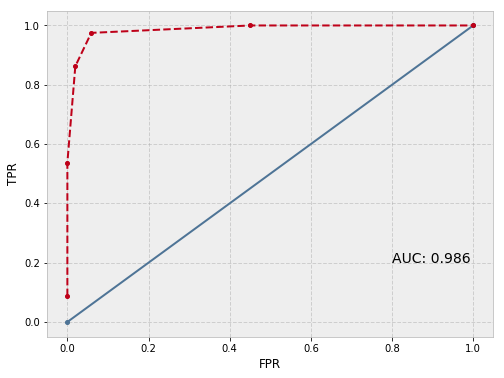

In [46]:
plot_roc_curve(models[1].named_steps['clf'], X_test, y_test)
plt.show()